In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import itertools
from tqdm.contrib.concurrent import process_map
import scipy

np.random.seed(42)

/opt/pypy/lib/pypy3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SAMPLE_SIZE = [10, 100, 1000, 10_000]
QUANTILES = [0.01, 0.05, 0.5]
DISTRIBUTIONS = {
    "NORMAL": {
        "gen": lambda n: np.random.normal(0, 1, n),
        "pdf": lambda xs: scipy.stats.norm.pdf(xs)
    },
    "UNIFORM": {
        "gen": lambda n: np.random.uniform(0, 1, n),
        "pdf": lambda xs: scipy.stats.uniform.pdf(xs)
    }
}
PRECISION = 1000
SIGMA = 0.05
EPS_ZERO = 0.005
X_SPACE = np.linspace(0, 1, PRECISION)
NUM_EXPERIMENTS = 1000
EXPERIMENT_PARAMS = tuple(itertools.product(DISTRIBUTIONS.keys(), SAMPLE_SIZE))
WITH_ANALYSE = False
OUT_FILE_CSV = "quantiles.csv"

In [31]:
def histogram_nbins(n):
    return math.floor(1 + 1.59 * math.log(n))


def gaussian_kernel(x, sigma):  # N_0,σ
    return (1 / np.sqrt(2 * np.pi) / sigma) * np.exp(-0.5 * x**2 / sigma**2)


def dup(arr):
    return np.array(list(map(lambda x: [x, x], arr))).flatten()


def make_kde(sample, xs, sigma):
    return scipy.stats.gaussian_kde(sample).pdf(xs)
    kde = np.array(sum(map(lambda x: gaussian_kernel((xs - x), sigma), sample)))
    kde = kde / len(sample)
    return kde


def make_hist(rs, bins):
    return np.histogram(rs, bins)


def make_ecdf(sample):
    sorted_sample = np.sort(sample)
    cdf_sample = np.cumsum(sorted_sample)
    cdf_sample = cdf_sample / cdf_sample[-1]
    return cdf_sample


def make_cdf(sample, xs):
    sorted_sample = np.sort(sample)
    cdf = np.searchsorted(sorted_sample, xs, side="right")
    cdf = cdf / len(sample)  # values on [0; 1]
    return cdf

In [29]:
def sample_quantile(sample, qs):
    assert all(0 <= q <= 1 for q in qs)
    assert len(sample) > 0

    return np.quantile(sample, qs)

    sorted_sample = np.sort(sample)

    xqs = []
    for q in qs:
        i = int((len(sample) - 1) * q)

        xqs.append(
            sorted_sample[i]
            if i % 1 == 0
            else q * (sorted_sample[math.floor(i)] + sorted_sample[math.ceil(i)])
        )
    return np.array(xqs)


def cdf_quantile(sample, cdf, qs):
    assert len(sample) == len(cdf)
    assert all(0 <= q <= 1 for q in qs)
    i = np.searchsorted(cdf, qs)
    return sample[i]


def hist_quantile(hist, bins, qs):
    assert all(0 <= q <= 1 for q in qs)

    pdf_hist = hist / sum(hist)
    cdf_hist = np.cumsum(pdf_hist)
    i = np.searchsorted(cdf_hist, qs)
    qs_diff = qs - np.insert(cdf_hist, 0, 0)[i]
    bin_width = bins[1] - bins[0]
    qs_height = pdf_hist[i]
    qs_diff_width = qs_diff / qs_height
    xqs = bins[i] + qs_diff_width * bin_width
    return xqs


def kde_quantile(phi, xs, qs):
    assert len(phi) == len(xs)
    cdf_kde = np.cumsum(phi)
    cdf_kde = cdf_kde / cdf_kde[-1]
    return cdf_quantile(xs, cdf_kde, qs)

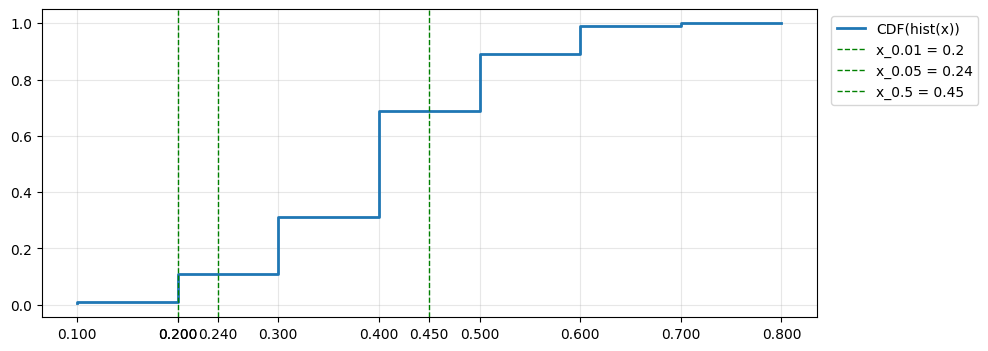

In [5]:
def test_hist():
    scale = 0.1
    hist = np.array([0.01, 0.1, 0.2, 0.38, 0.2, 0.1, 0.01])
    bins = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]) * scale
    qs = QUANTILES

    cdf_hist = np.insert(np.cumsum(hist) / np.sum(hist), 0, EPS_ZERO)
    plt.figure(figsize=(10, 4))
    plt.plot(
        np.insert(dup(bins)[:-1], 0, float("-inf")),
        dup(cdf_hist),
        label="CDF(hist(x))",
        linewidth=2,
    )
    hist_qs = hist_quantile(hist, bins, qs)
    for hist_qi, qi in zip(hist_qs, qs):
        plt.axvline(
            hist_qi,
            color="g",
            linestyle="--",
            label=f"x_{qi} = {round(hist_qi, 4)}",
            linewidth=1,
        )
    plt.xticks(
        list(bins) + list(hist_qs),
        [f"{b:.3f}" for b in bins] + [f"{q:.3f}" for q in hist_qs],
    )
    plt.plot()
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.show()


test_hist()

In [34]:
def analyze(dist_name, sample_size, qs, sigma=SIGMA):
    sample = DISTRIBUTIONS[dist_name]["gen"](sample_size)
    xs = np.linspace(np.min(sample) - 1, np.max(sample) + 1, PRECISION)
    plt.figure(figsize=(10, 3))

    true_pdf = DISTRIBUTIONS[dist_name]["pdf"](xs)
    plt.plot(xs, true_pdf, "k-", lw=2, label="Реальная плотность")
    ecdf_qs = sample_quantile(sample, qs)
    for ecdf_qi, qi in zip(ecdf_qs, qs):
        plt.axvline(
            ecdf_qi,
            color="k",
            linestyle="--",
            label=f"x_{qi} = {round(ecdf_qi, 4)} ({np.mean(sample < ecdf_qi)})",
            linewidth=1,
        )

    hist, bins = make_hist(sample, histogram_nbins(sample_size))
    plt.hist(
        sample, bins=bins, density=True, color="skyblue", alpha=0.6, label="Гистограмма"
    )
    hist_qs = hist_quantile(hist, bins, qs)
    for hist_qi, qi in zip(hist_qs, qs):
        plt.axvline(
            hist_qi,
            color="b",
            linestyle="--",
            label=f"x_{qi} = {round(hist_qi, 4)} ({np.mean(sample < hist_qi)})",
            linewidth=1,
        )

    kde_pdf = make_kde(sample, xs, sigma)
    plt.plot(xs, kde_pdf, "r-", label="KDE")
    kde_qs = kde_quantile(kde_pdf, xs, qs)
    for kde_qi, qi in zip(kde_qs, qs):
        plt.axvline(
            kde_qi,
            color="r",
            linestyle="--",
            label=f"x_{qi} = {round(kde_qi, 4)} ({np.mean(sample < kde_qi)})",
            linewidth=1,
        )


    plt.title(f"Распределение {dist_name}, n={sample_size}")
    plt.xlabel("x")
    plt.ylabel("Плотность")
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.grid(True)
    plt.show()

SIGMA=0.05


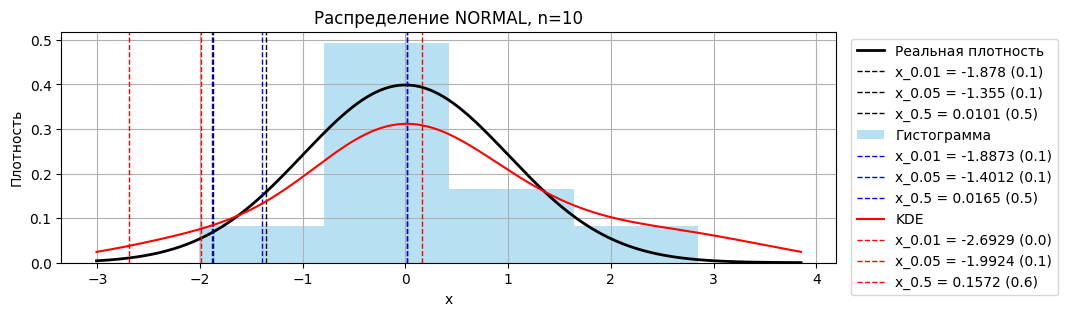

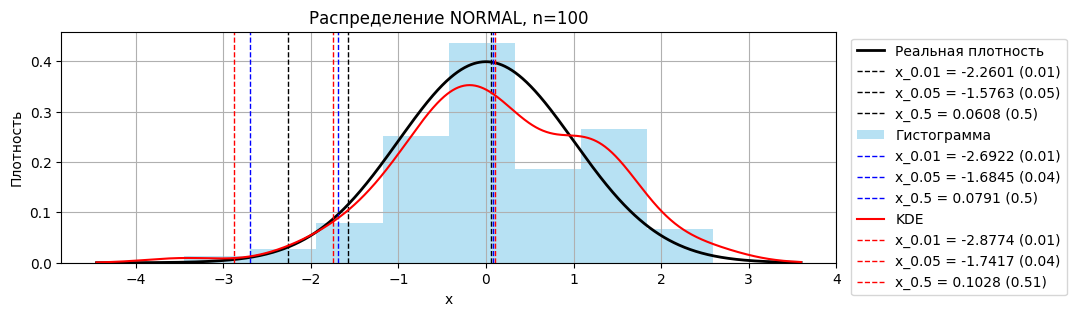

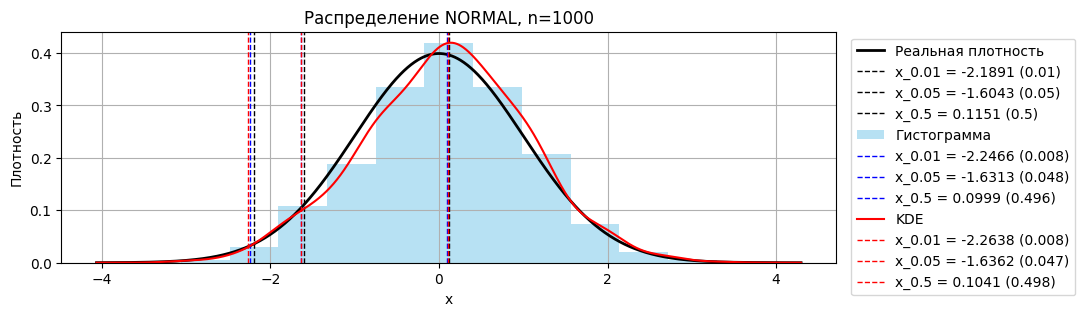

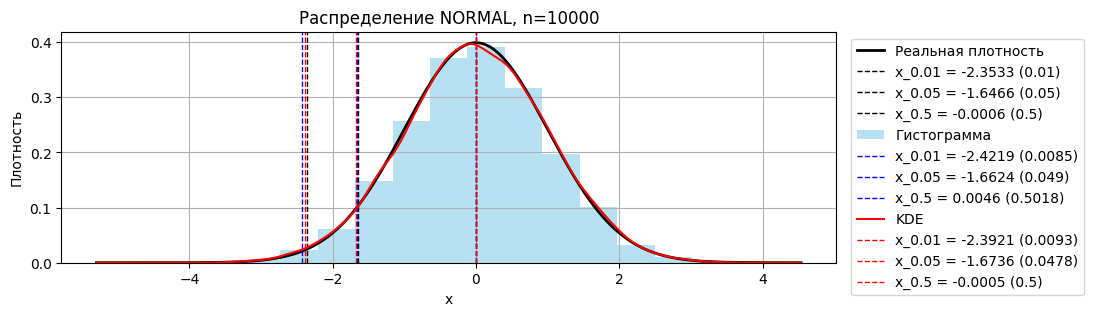

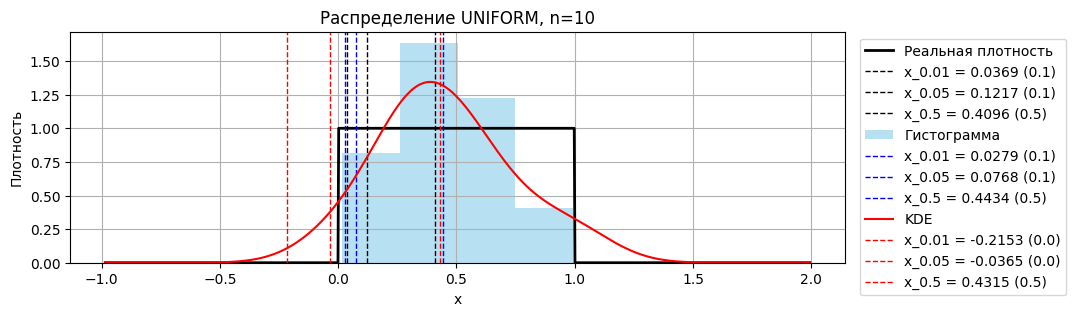

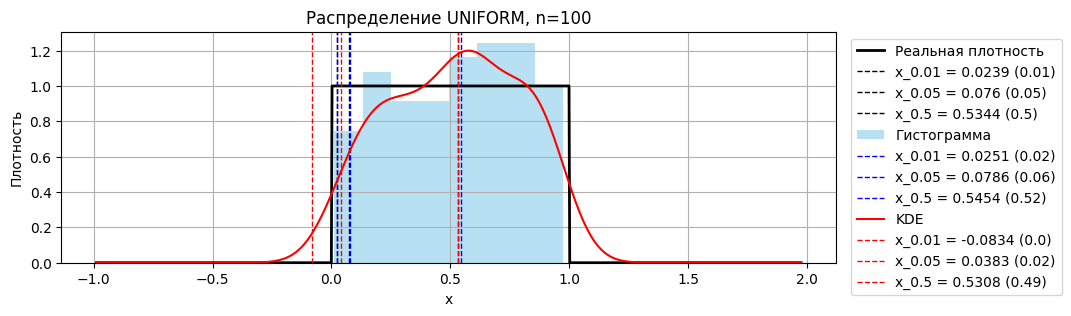

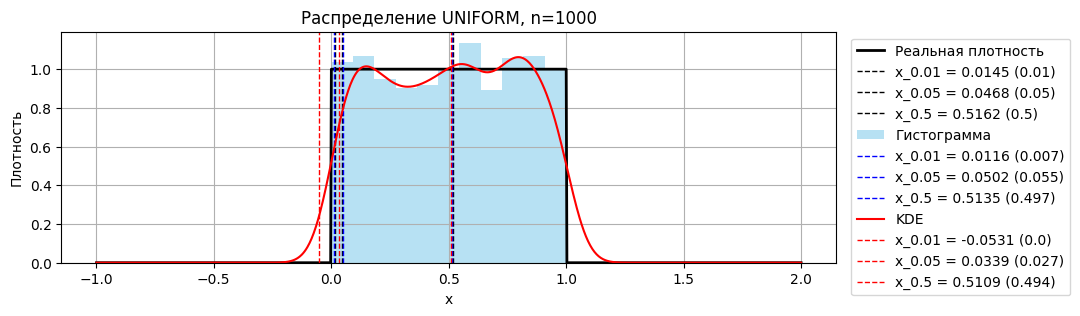

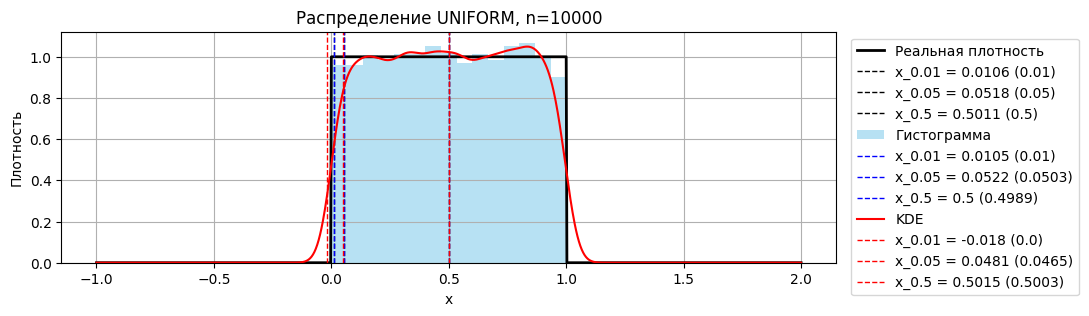

In [36]:
if True or WITH_ANALYSE:
    print(f"{SIGMA=}")
    for d, s in itertools.product(DISTRIBUTIONS, SAMPLE_SIZE):
        analyze(d, s, QUANTILES, sigma=SIGMA)

In [37]:
def experiment(args):
    (dist_name, sample_size), iter = args
    sample = DISTRIBUTIONS[dist_name]["gen"](sample_size)
    xs = np.linspace(np.min(sample) - 1, np.max(sample) + 1, PRECISION)

    hist, bins = make_hist(sample, histogram_nbins(sample_size))
    hist_qs = hist_quantile(hist, bins, QUANTILES)

    kde_pdf = make_kde(sample, xs, SIGMA)
    kde_qs = kde_quantile(kde_pdf, xs, QUANTILES)

    ecdf_qs = sample_quantile(sample, QUANTILES)

    results = [
        [
            (dist_name, sample_size, iter, "emp", qi, ecdf_qs[i]),
            (dist_name, sample_size, iter, "hist", qi, hist_qs[i]),
            (dist_name, sample_size, iter, "kde", qi, kde_qs[i]),
        ]
        for i, qi in enumerate(QUANTILES)
    ]
    return results

In [ ]:
n_exp = NUM_EXPERIMENTS
rsss = process_map(
    experiment,
    itertools.product(
        EXPERIMENT_PARAMS,
        range(n_exp),
    ),
)

32it [00:03,  8.90it/s]


In [45]:
data = [r for rss in rsss for rs in rss for r in rs]

In [46]:
df = pd.DataFrame(data, columns=("dist_name", "sample_size", "exp_iter", "exp_type", "quantile", "q_val"))
df.to_csv("test_" + OUT_FILE_CSV, index=False)

In [47]:
df = pd.read_csv("test_" + OUT_FILE_CSV)
df

,dist_name,sample_size,exp_iter,exp_type,quantile,q_val
0,NORMAL,10,0,emp,0.01,-1.672321
1,NORMAL,10,0,hist,0.01,-1.656364
2,NORMAL,10,0,kde,0.01,-2.546750
3,NORMAL,10,0,emp,0.05,-1.621787
4,NORMAL,10,0,hist,0.05,-1.541999
...,...,...,...,...,...,...
283,UNIFORM,10000,3,hist,0.05,0.048832
284,UNIFORM,10000,3,kde,0.05,0.045061
285,UNIFORM,10000,3,emp,0.50,0.494506
286,UNIFORM,10000,3,hist,0.50,0.494496


In [48]:
# ...existing code...
def plot_quantile_std(df, figsize_per_q=(5, 4), logx=True, save_prefix=None):
    """
    Plot std(q_val) over exp_iter grouped by sample_size and exp_type.
    - df: DataFrame with columns ('dist_name','sample_size','exp_iter','exp_type','quantile','q_val')
    - figsize_per_q: (width,height) per quantile subplot
    - logx: use log scale for sample_size axis
    - save_prefix: if provided, save each distribution figure to '{save_prefix}_{dist}.png'
    """
    distributions = sorted(df["dist_name"].unique())
    quantiles = sorted(df["quantile"].unique())

    figs = {}
    for dist in distributions:
        df_dist = df[df["dist_name"] == dist]
        if df_dist.empty:
            continue

        df_dist_stdq = (
            df_dist.groupby(["sample_size", "exp_type", "quantile"])["q_val"]
            .std()
            .reset_index()
        )

        n_q = len(quantiles)
        fig, axes = plt.subplots(
            1, n_q, figsize=(figsize_per_q[0] * n_q, figsize_per_q[1]), squeeze=False
        )

        for i, q in enumerate(quantiles):
            ax = axes[0, i]
            method_stdq_by_sample_size = (
                df_dist_stdq[df_dist_stdq["quantile"] == q]
                .pivot(index="sample_size", columns="exp_type", values="q_val")
                .sort_index()
            )
            sample_sizes = method_stdq_by_sample_size.index.values
            for method in method_stdq_by_sample_size.columns:
                stdqs = method_stdq_by_sample_size[method].values
                ax.plot(sample_sizes, stdqs, marker="o", label=str(method))
            ax.set_title(f"{dist} — quantile={q}")
            ax.set_xlabel("sample_size")
            ax.set_ylabel("std(q_val)")
            if logx:
                ax.set_xscale("log")
                ax.set_xticks(sorted(sample_sizes))
                ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
            ax.grid(alpha=0.3)

        axes[0, -1].legend(loc="upper right", fontsize="small")
        plt.tight_layout()

        if save_prefix:
            fname = f"{save_prefix}_{dist}.png"
            fig.savefig(fname, dpi=150, bbox_inches="tight")
        figs[dist] = fig
        plt.show()

    return figs

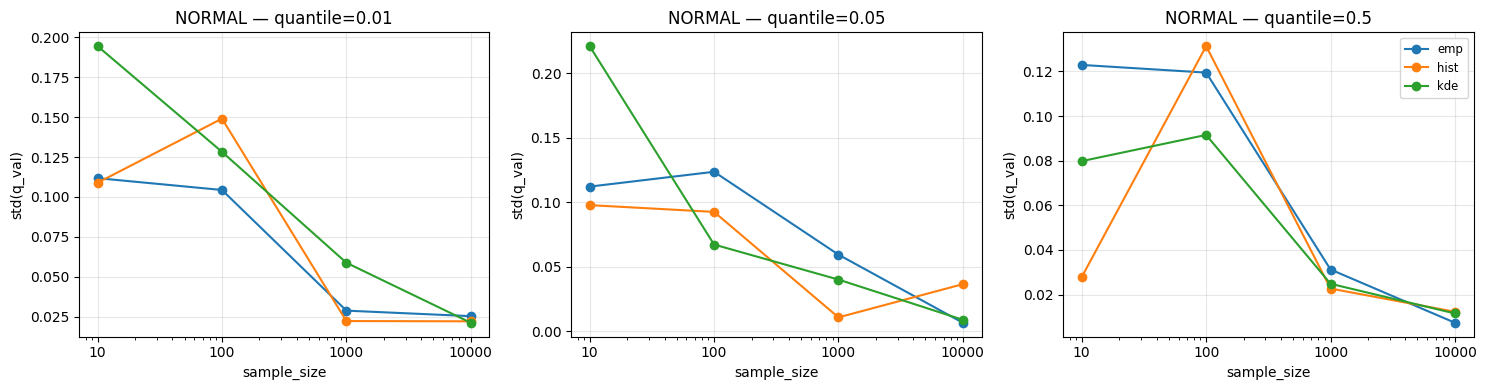

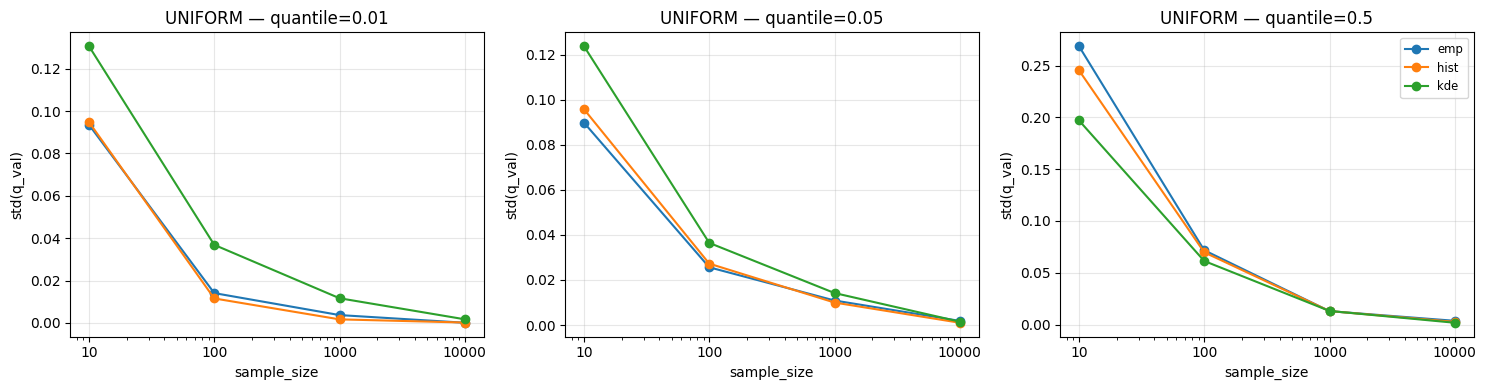

{'NORMAL': <Figure size 1500x400 with 3 Axes>,
 'UNIFORM': <Figure size 1500x400 with 3 Axes>}

In [49]:
plot_quantile_std(df)